In [1]:
import random

import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer, DataCollatorForSeq2Seq

from lema.datasets.alpaca import AlpacaDataset
from lema.datasets.chatqa import ChatqaDataset

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

### 1. Listing Supported Datasets

In [3]:
from lema.core.registry import REGISTRY, RegistryType


def list_datasets():
    """List all datasets in the registry."""
    for key, value in REGISTRY._registry.items():
        if key.registry_type == RegistryType.DATASET:
            print(key.name, "->", value.__name__)


list_datasets()

tatsu-lab/alpaca -> AlpacaDataset
yahma/alpaca-cleaned -> AlpacaDataset
nvidia/ChatQA-Training-Data -> ChatqaDataset


### 2. Loading Datasets

We load the alpaca dataset. Since multiple variants can be registered in the HuggingFace hub, by default we use `Dataset.default`.

In [4]:
%%time

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

/Users/oussamaelachqar/miniconda3/envs/dev/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


CPU times: user 80.4 ms, sys: 11.5 ms, total: 92 ms
Wall time: 241 ms


In [3]:
%%time

dataset = AlpacaDataset(tokenizer=tokenizer)

print(f"Using: {dataset.dataset_name_or_path}")

Using: tatsu-lab/alpaca
CPU times: user 164 ms, sys: 58.6 ms, total: 222 ms
Wall time: 2.47 s


Alternatively, you can pass a custom HuggingFace hub identifier. You can find a list of supported datasets in `Dataset.supported_datasets`

In [6]:
%%time

dataset = AlpacaDataset(
    dataset_name_or_path="yahma/alpaca-cleaned", tokenizer=tokenizer
)

print(f"Using: {dataset.dataset_name_or_path}")

Using: yahma/alpaca-cleaned
CPU times: user 146 ms, sys: 33.3 ms, total: 179 ms
Wall time: 1.97 s


Under the hood, the dataset is downloaded from the HuggingFace hub, and cached in the `~/.cache/huggingface/datasets` directory.

When instantiating the class, the dataset is loaded in memory. This is acceptable with small datasets, but for larger datasets, we can either use `IterableDataset` for streaming batch from disk, or shard per worker rank (so that Memory // N_GPUs).

Finally, you can also load a dataset from a local `jsonl` or `parquet` file.

In [40]:
# dataset = LemaSftDataset(dataset_name_or_path="./sft.jsonl", tokenizer=tokenizer)
# dataset = LemaSftDataset(dataset_name_or_path="./sft.parquet", tokenizer=tokenizer)

### 3. Iterating Over Dataset

In [7]:
print(f"Number of examples: {len(dataset)}")

Number of examples: 51760


Given everything is loaded into memory, we can randomly access any row in the dataset:

In [8]:
%%timeit

dataset[42]


No chat template is defined for this tokenizer - using the default template for the GPT2TokenizerFast class. If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



269 µs ± 6.45 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


We can iterate over the dataset to get the examples, either manually or using a DataLoader.

In [9]:
%%time

# Manual iteration
[dataset[i] for i in range(len(dataset))];

CPU times: user 16.2 s, sys: 216 ms, total: 16.4 s
Wall time: 16.5 s


In [13]:
%%time

# With a pytorch data loader
loader = DataLoader(
    dataset, batch_size=1, num_workers=0, shuffle=False, collate_fn=lambda x: x
)
list(loader);

CPU times: user 16.1 s, sys: 147 ms, total: 16.2 s
Wall time: 16.3 s


We can also use any library from the pytorch ecosystem, e.g. `torchtext`, `torchdata`, etc.

In [14]:
from torchdata.stateful_dataloader import StatefulDataLoader

loader = StatefulDataLoader(dataset, batch_size=1, num_workers=0, shuffle=False)

In [17]:
loader.state_dict()

{'_index_sampler_state': {'samples_yielded': 1},
 '_sampler_iter_state': None,
 '_sampler_iter_yielded': 1,
 '_num_yielded': 1,
 '_IterableDataset_len_called': None,
 '_shared_seed': None,
 'fetcher_state': None,
 'dataset_state': None,
 '_iterator_finished': False}

In [16]:
next(iter(loader));

### 4. Accessing Individual Examples

Alpaca is a "Supervised Finetuning Dataset". It contains instructions, user inputs, and model outputs. An SFT dataset has the following methods:

**Base Map Dataset**
```python
dataset[0] -> model inputs  # pytorch convention
dataset.raw(0) -> raw data  # lema convention
```
**Base SFT Dataset**
```python
dataset.conversation(0) -> conversation # model independent
dataset.prompt(0) -> prompt  # dependends on the tokenizer
```

In [18]:
# Raw data (pd.Series, dict), as defined by the dataset authors
dataset.raw(0)

output         1. Eat a balanced and nutritious diet: Make su...
input                                                           
instruction                 Give three tips for staying healthy.
Name: 0, dtype: object

In [19]:
# Convert to standard Lema SFT format (lema.core.types.Conversation)
dataset.conversation(0).messages

[Message(id=None, content='Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.', role=<Role.SYSTEM: 'system'>),
 Message(id=None, content='Give three tips for staying healthy.', role=<Role.USER: 'user'>),
 Message(id=None, content='1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.\n\n2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.\n\n3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive f

In [20]:
# Convert to model prompt (str). This include the model's chat temlate,
# EOS tokens for inference/generation, etc.
dataset.prompt(0)

'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.<|endoftext|>Give three tips for staying healthy.<|endoftext|>1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.\n\n2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.\n\n3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night.<|endoftext|>'

In [21]:
# What is fed to the model.forward (dict)
dataset[0]

{'input_ids': [21106, 318, 281, 12064, 326, 8477, 257, 4876, 11, 20312, 351, 281, 5128, 326, 3769, 2252, 4732, 13, 19430, 257, 2882, 326, 20431, 32543, 262, 2581, 13, 50256, 23318, 1115, 9040, 329, 10589, 5448, 13, 50256, 16, 13, 27574, 257, 12974, 290, 48102, 5496, 25, 6889, 1654, 534, 13840, 389, 19889, 286, 257, 4996, 286, 15921, 290, 13701, 11, 10904, 7532, 11, 2187, 21824, 11, 290, 5448, 27997, 13, 770, 5419, 284, 2148, 534, 1767, 351, 262, 6393, 20901, 284, 2163, 379, 663, 1266, 290, 460, 1037, 2948, 10726, 10040, 13, 198, 198, 17, 13, 1985, 496, 287, 3218, 3518, 3842, 25, 32900, 318, 8780, 329, 10941, 1913, 11945, 11, 12749, 11, 290, 21134, 1535, 13, 36223, 329, 379, 1551, 6640, 2431, 286, 10768, 43294, 5517, 393, 5441, 2431, 286, 31543, 5517, 1123, 1285, 13, 198, 198, 18, 13, 3497, 1576, 3993, 25, 18067, 1576, 3081, 3993, 318, 8780, 329, 3518, 290, 5110, 880, 12, 11873, 13, 632, 5419, 284, 16697, 10038, 11, 2987, 10870, 2163, 11, 290, 6971, 5448, 3349, 290, 10900, 2163, 13, 362

### 5. Accessing the underlying data backend (for debugging only)

We currently use pd.DataFrame as a backend for the dataset. We can trivially use either HuggingFace `datasets`, or an `arrow` Table as a backend for the dataset.

In [22]:
dataset.data.columns

Index(['output', 'input', 'instruction'], dtype='object')

In [23]:
dataset.data.head()

,output,input,instruction
0,1. Eat a balanced and nutritious diet: Make su...,,Give three tips for staying healthy.
1,"The three primary colors are red, blue, and ye...",,What are the three primary colors?
2,An atom is the basic building block of all mat...,,Describe the structure of an atom.
3,There are several ways to reduce air pollution...,,How can we reduce air pollution?
4,I had to make a difficult decision when I was ...,,Pretend you are a project manager of a constru...


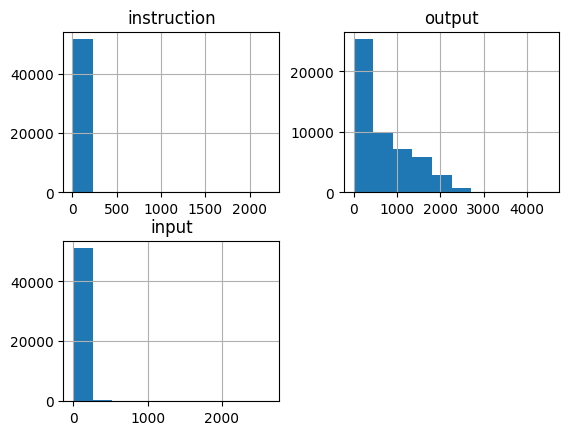

In [24]:
dataset.data[["instruction", "output", "input"]].map(len).hist();

### 6. Preprocessing

To customize preprocessing behavior, we can override the appropriate method:
- `BaseMapDataset.__getitem__` for fully custom behavior, multi-modal, multi-task, etc.
- `BaseMapDataset.transform` for custom preprocessing of standard datasets (inputs, labels)
- `BaseSftDataset.transform` To customize preprocessing, tokenization of a standard SFT dataset
- `BaseSftDataset.transform_conversation` To transform raw data row into lema conversation
- `LemaSftDataset` -> If raw data already in Lema format, no custom class needed!

In [25]:
dataset = AlpacaDataset(tokenizer=tokenizer)

print(f"Using: {dataset.dataset_name_or_path}")

Using: tatsu-lab/alpaca


In [ ]:
%%timeit

dataset.raw(0)

In [33]:
%%timeit

idx = random.randint(0, len(dataset) - 1)
dataset.raw(idx)

6.29 µs ± 52.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [35]:
%%timeit

idx = random.randint(0, len(dataset) - 1)
dataset.conversation(idx)

15.9 µs ± 463 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [36]:
%%timeit

idx = random.randint(0, len(dataset) - 1)
dataset.prompt(idx)

27.5 µs ± 180 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [37]:
%%timeit

idx = random.randint(0, len(dataset) - 1)
dataset[idx]

224 µs ± 5.24 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## 7. Comparing with other datasets

In [38]:
import datasets

In [42]:
hf_dataset = datasets.load_dataset("tatsu-lab/alpaca")
hf_dataset = hf_dataset["train"]

#### Raw Random Access

In [43]:
%%timeit

idx = random.randint(0, len(dataset) - 1)
dataset.raw(idx)  # use lema dataset random access

6.27 µs ± 125 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [44]:
%%timeit

idx = random.randint(0, len(dataset) - 1)
hf_dataset[idx]  # use huggingface dataset random access

21.4 µs ± 361 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [95]:
%%timeit

idx = random.randint(0, len(dataset) - 1)
hf_dataset.data["text"][idx].as_py()  # directly access the arrow table.

2.07 µs ± 35 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


#### With Tokenization

In [93]:
%%timeit

# Arrow
dataset.tokenize(hf_dataset.data["text"][0].as_py())

649 µs ± 19 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [98]:
%%timeit

# HF Datasets
idx = random.randint(0, len(dataset) - 1)
dataset.tokenize(hf_dataset[idx])

54.3 µs ± 978 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [101]:
%%timeit

# Lema dataset
idx = random.randint(0, len(dataset) - 1)
dataset.tokenize(dataset.raw(idx))

44.3 µs ± 1.39 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [99]:
%%timeit

# Full lema pipeline
idx = random.randint(0, len(dataset) - 1)
dataset[idx]

213 µs ± 3.98 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Iterate over dataset

In [102]:
%%timeit

# Manual iteration
[dataset[i] for i in range(len(dataset))];

10.5 s ± 129 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit

# With a pytorch data loader
loader = DataLoader(dataset, batch_size=1, num_workers=0, shuffle=False)
list(loader);

In [40]:
%prun [dataset[i] for i in range(len(dataset))];

         21800369 function calls (21748606 primitive calls) in 23.434 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    51760   14.265    0.000   14.265    0.000 {method 'encode_batch' of 'tokenizers.Tokenizer' objects}
   103520    1.456    0.000    1.456    0.000 {built-in method torch.tensor}
        1    0.396    0.396   23.434   23.434 <string>:1(<module>)
   207040    0.367    0.000    0.611    0.000 {method 'validate_python' of 'pydantic_core._pydantic_core.SchemaValidator' objects}
  4547145    0.355    0.000    0.575    0.000 {built-in method builtins.isinstance}
   207040    0.259    0.000    0.294    0.000 enum.py:686(__call__)
   226197    0.197    0.000    0.719    0.000 series.py:1085(__getitem__)
   155280    0.190    0.000    0.294    0.000 sandbox.py:125(is_internal_attribute)
    51760    0.182    0.000   19.989    0.000 tokenization_utils_base.py:1684(apply_chat_template)
    51760    0.181    0.000    

In [43]:
%lprun -f dataset.__getitem__ [dataset[i] for i in range(len(dataset))];

Timer unit: 1e-09 s

Total time: 21.6536 s
File: /Users/oussamaelachqar/source/lema/lema/src/lema/core/types/base_dataset.py
Function: __getitem__ at line 51

Line #      Hits         Time  Per Hit   % Time  Line Contents
    51                                               def __getitem__(self, idx: int) -> Union[Conversation, dict]:
    52                                                   """Gets the item at the specified index.
    53                                           
    54                                                   Args:
    55                                                       idx (int): The index of the item to retrieve.
    56                                           
    57                                                   Returns:
    58                                                       dict: The item at the specified index.
    59                                                   """
    60     51760 1041049000.0  20113.0      4.8          sample = se

In [45]:
%memit [dataset[i] for i in range(len(dataset))]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 3034.42 MiB, increment: 317.41 MiB


## 8. Benchmark with Model Forward Pass

In [103]:
%%time

model = AutoModelForCausalLM.from_pretrained("gpt2")

/Users/oussamaelachqar/miniconda3/envs/dev/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


CPU times: user 731 ms, sys: 1.02 s, total: 1.75 s
Wall time: 624 ms


In [107]:
%%time

dataset = AlpacaDataset(tokenizer=tokenizer)
collator_fn = DataCollatorForSeq2Seq(tokenizer=tokenizer, return_tensors="pt")

loader = DataLoader(
    dataset, batch_size=3, num_workers=0, shuffle=False, collate_fn=collator_fn
)

CPU times: user 156 ms, sys: 28.9 ms, total: 185 ms
Wall time: 1.79 s


In [108]:
%%timeit

# Including pre-processing
with torch.no_grad():
    batch = next(iter(loader))
    model.forward(**batch)

103 ms ± 1.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [109]:
fixed_batch = next(iter(loader))

In [110]:
%%timeit

# Excluding pre-processing
with torch.no_grad():
    model.forward(**fixed_batch)

102 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 9. Sanity Check Datasets

In [5]:
dataset = ChatqaDataset(tokenizer=tokenizer, subset="drop")

In [7]:
dataset.raw(0)

answers                                             [28-yard]
messages    [{'content': 'How long was the Lion's longest ...
document    To start the season, the Lions traveled south ...
Name: 0, dtype: object

In [8]:
dataset.conversation(0).messages

[Message(id=None, content='Answer the following question with a short span.', role=<Role.SYSTEM: 'system'>),
 Message(id=None, content='Only use the information from the user provided context to answer the question.', role=<Role.SYSTEM: 'system'>),
 Message(id=None, content="<context>To start the season, the Lions traveled south to Tampa, Florida to take on the Tampa Bay Buccaneers. The Lions scored first in the first quarter with a 23-yard field goal by Jason Hanson. The Buccaneers tied it up with a 38-yard field goal by Connor Barth, then took the lead when Aqib Talib intercepted a pass from Matthew Stafford and ran it in 28 yards. The Lions responded with a 28-yard field goal. In the second quarter, Detroit took the lead with a 36-yard touchdown catch by Calvin Johnson, and later added more points when Tony Scheffler caught an 11-yard TD pass. Tampa Bay responded with a 31-yard field goal just before halftime. The second half was relatively quiet, with each team only scoring one tou

In [9]:
dataset.prompt(0)

"Answer the following question with a short span.<|endoftext|>Only use the information from the user provided context to answer the question.<|endoftext|><context>To start the season, the Lions traveled south to Tampa, Florida to take on the Tampa Bay Buccaneers. The Lions scored first in the first quarter with a 23-yard field goal by Jason Hanson. The Buccaneers tied it up with a 38-yard field goal by Connor Barth, then took the lead when Aqib Talib intercepted a pass from Matthew Stafford and ran it in 28 yards. The Lions responded with a 28-yard field goal. In the second quarter, Detroit took the lead with a 36-yard touchdown catch by Calvin Johnson, and later added more points when Tony Scheffler caught an 11-yard TD pass. Tampa Bay responded with a 31-yard field goal just before halftime. The second half was relatively quiet, with each team only scoring one touchdown. First, Detroit's Calvin Johnson caught a 1-yard pass in the third quarter. The game's final points came when Mike 

In [10]:
dataset[0]

{'input_ids': [33706, 262, 1708, 1808, 351, 257, 1790, 11506, 13, 50256, 10049, 779, 262, 1321, 422, 262, 2836, 2810, 4732, 284, 3280, 262, 1808, 13, 50256, 27, 22866, 29, 2514, 923, 262, 1622, 11, 262, 14536, 14113, 5366, 284, 15528, 11, 4744, 284, 1011, 319, 262, 15528, 4696, 37006, 13, 383, 14536, 7781, 717, 287, 262, 717, 3860, 351, 257, 2242, 12, 9413, 2214, 3061, 416, 8982, 35692, 13, 383, 37006, 8165, 340, 510, 351, 257, 4353, 12, 9413, 2214, 3061, 416, 27599, 44414, 11, 788, 1718, 262, 1085, 618, 317, 80, 571, 7193, 571, 29842, 257, 1208, 422, 9308, 30596, 290, 4966, 340, 287, 2579, 5695, 13, 383, 14536, 7082, 351, 257, 2579, 12, 9413, 2214, 3061, 13, 554, 262, 1218, 3860, 11, 8488, 1718, 262, 1085, 351, 257, 4570, 12, 9413, 10242, 4929, 416, 25017, 5030, 11, 290, 1568, 2087, 517, 2173, 618, 8832, 10011, 487, 1754, 4978, 281, 1367, 12, 9413, 13320, 1208, 13, 15528, 4696, 7082, 351, 257, 3261, 12, 9413, 2214, 3061, 655, 878, 35185, 13, 383, 1218, 2063, 373, 5365, 5897, 11, 351, 